In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.regression.compose._ensemble import ComposableTimeSeriesForestRegressor
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

In [3]:
# load data

pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/project/wearables/model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
trainer = loadpkl(bst_trainer)

if False:
    # call eval to get output, modify for return_hidden = True option
    evaluation = weareval.eval_trained(trainer, split='train',
                                       modelpkl=bst_modelpkl,
                                       two_outputs=True)

# show error in train and test set 

In [6]:
# define parameters
idxs = trainer.data.train_ids
threshold = 10 # for error groups

savefigs = False

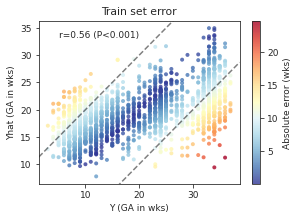

In [7]:
# parse data and plot
y = md.loc[idxs, 'y']
yhat = md.loc[idxs, 'yhat']
error = md.loc[idxs, 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Train set error')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_train.pdf'), bbox_inches='tight')

### assign error grp

In [8]:
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [9]:
md.loc[idxs, 'Error group'].value_counts()

lt10wks               1300
Lower-than-actual      267
Higher-than-actual     159
Name: Error group, dtype: int64

In [10]:
errgrp_cmap = {'lt{}wks'.format(threshold): '#4297A0', # green
               'Higher-than-actual': '#E57F84', #red
               'Lower-than-actual': '#2F5061', # blue
               }

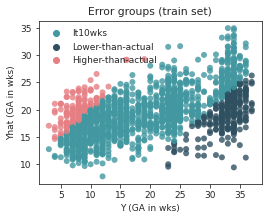

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='y', y='yhat', hue='Error group', data=md.loc[idxs], palette=errgrp_cmap, linewidth=0, alpha=0.8, ax=ax)
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Error groups (train set)')
ax.legend().set_title('')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_train_errorgroups.pdf'), bbox_inches='tight')

## chk the same in the test set m

In [12]:
# define parameters
idxs = trainer.data.test_ids

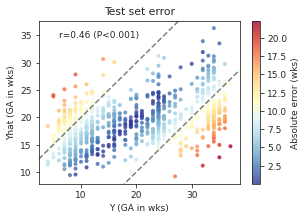

In [13]:
# parse data and plot
y = md.loc[idxs, 'y']
yhat = md.loc[idxs, 'yhat']
error = md.loc[idxs, 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Test set error')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_test.pdf'), bbox_inches='tight')

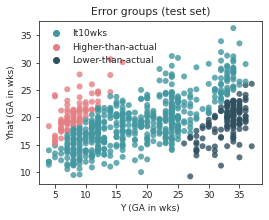

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='y', y='yhat', hue='Error group', data=md.loc[idxs], palette=errgrp_cmap, linewidth=0, alpha=0.8, ax=ax)
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Error groups (test set)')
ax.legend().set_title('')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_test_errorgroups.pdf'), bbox_inches='tight')

In [15]:
md.loc[idxs, 'Error group'].value_counts()

lt10wks               518
Lower-than-actual     129
Higher-than-actual     90
Name: Error group, dtype: int64

# md differences across err grp

In [16]:
# grab list of vars to predict (mdpred_voi)
from wearables.scripts.md_specification import mdpred_voi

In [17]:
class dataloader():
    '''Load data into numpy data types and specify number of folds. If kfold=1 or 0, then single val set returned.
    '''
    def __init__(self, target_name='GA', 
                 kfold=5, prop_trainset=1., 
                 include_lux=False, 
                 filename='/home/ngrav/data/wearables/processed/MOD1000_modeldata.pkl',
                 pp_md_fp=os.path.join(pfp, 'md_v522_220124.csv')):
        self.rawdata_file = filename
        self.data = self.load_preproced(filename)
        self.target_name = target_name
        self.kfold = kfold
        self.prop_trainset = prop_trainset
        self.include_lux = include_lux
        if pp_md_fp is not None:
            self.md = pd.read_csv(pp_md_fp, index_col=0)
        else:
            self.md = None
        self.ids = list(self.data['IDs'].keys())
        
        # split data and get dataloaders
        self.split_data()
        self.Xy_train, self.Xy_test = self.get_Xy(self.target_name)
        
    def load_preproced(self, filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    
    def split_data(self, train_ratio=0.8):
        pids = np.unique([i.split('_')[0] for i in self.data['IDs'].keys()])
        train_pids = np.random.choice(pids, int(len(pids)*train_ratio*self.prop_trainset), replace=False)
        test_pids = [i for i in pids if i not in train_pids]
        if self.kfold <= 1: # create single val set
            val_pids = np.random.choice(test_pids, int(len(test_pids)*0.5), replace=False)
            # no overlap between val/test? or merge val into test?
            # test_pids = [i for i in test_pids if i not in val_pids]
            self.val_ids = [i for i in self.data['IDs'].keys() if i.split('_')[0] in val_pids]
        else:
            self.train_ids = np.array_split(train_pids, self.kfold)
            for ii, fold in enumerate(self.train_ids):
                self.train_ids[ii] = [i for i in self.data['IDs'].keys() if i.split('_')[0] in self.train_ids[ii]]
        self.test_ids = [i for i in self.data['IDs'].keys() if i.split('_')[0] in test_pids]
        return None

    def Xy_from_id(self, ids, target_name):
        for i, k in enumerate(ids):
            if self.include_lux:
                x = np.concatenate((self.data['data'][k]['activity'].to_numpy(dtype=np.float32)[:-1].reshape(-1, 1), 
                                    self.data['data'][k]['light'].to_numpy(dtype=np.float32)[:-1].reshape(-1, 1)), 
                                    1) 
            else:
                x = self.data['data'][k]['activity'].to_numpy(dtype=np.float32)[:-1]
            if i==0:
                X = np.zeros(shape=(len(ids), *x.shape))
                y = np.zeros(shape=(len(ids), ))
            X[i] = x
            if target_name == 'GA':
                y[i] = np.float32(k.split('_')[-1])
            else:
                if self.md is None:
                    y[i] = np.float32(self.data['data'][k]['md'][target_name])
                else:
                    y[i] = np.float32(self.md.loc[k, target_name].item())
                    
        # define in terms of category class
        try:
            enc = self.data['cat_class_enc'][target_name]
        except KeyError:
            enc = None
        if enc is not None and len(enc.keys()) > 2:
            # force to wide 
            y_wide = np.zeros(shape=(y.shape[0], len(enc.keys())), dtype=np.float32)
            y_wide[np.arange(y.shape[0]), np.array(y, dtype=int)] = 1.
            y = y_wide # force multiclass classification, check cat_class_enc for meaning
        return X, y

    def get_Xy(self, target_name):
        # train, if CV, dict with [(X_train, y_train), (X_val, y_val)] else (X_train, y_train)
        Xy_test = self.Xy_from_id(self.test_ids, target_name)
        if self.kfold > 1:
            Xy_train = {}
            Xy_cv = {}
            for k, fold_ids in enumerate(self.train_ids):
                Xy_cv[k] = (self.Xy_from_id(fold_ids, target_name))
            # now concatenate others, shifting single to others
            for kfold in Xy_cv.keys():
                for i, kk in enumerate([k for k in Xy_cv.keys() if k != kfold]):
                    X, y = Xy_cv[kk]
                    if i==0:
                        X_cv, y_cv = X.copy(), y.copy()
                    else:
                        X_cv = np.concatenate((X_cv, X), 0)
                        y_cv = np.concatenate((y_cv, y), 0)
                Xy_train[kfold] = [(X_cv, y_cv), Xy_cv[kfold]]
            return Xy_train, Xy_test
        else:
            Xy_train = self.Xy_from_id(self.train_ids, target_name)
            Xy_val = self.Xy_from_id(self.val_ids, target_name)
            return Xy_train, Xy_val, Xy_test


In [18]:
class kNN():
    def __init__(self, n_trials=1, target_name='GA', tasktype='regression'):
        self.n_trials = n_trials
        self.target_name = target_name
        self.tasktype = tasktype
    
        
    def load_data(self):
        return dataloader(target_name=self.target_name)
        
    def fit(self, data):
        if data.kfold > 1:
            cv_eval = {}
            for k, cv_fold in enumerate(data.Xy_train.keys()):
                [(X_train, y_train), (X_val, y_val)] = data.Xy_train[cv_fold]
                kNN = KNeighborsRegressor(n_jobs=16) if self.tasktype=='regression' else KNeighborsClassifier(n_jobs=16)
                kNN.fit(X_train, y_train)
                eval_metrics = weareval.eval_output(kNN.predict(X_val), y_val, tasktype=self.tasktype)
                cv_eval[cv_fold] = {'model': kNN, 
                                    # 'data': [(X_train, y_train), (X_val, y_val)], # store just IDs?
                                    'metric': eval_metrics['mae'] if self.tasktype=='regression' else eval_metrics['balanced_acc_adj'],
                                    'metrics': eval_metrics}
            # retain only best model
            tmp = {cv_fold:cv_eval[cv_fold]['metric'] for cv_fold in cv_eval.keys()}
            bst_fold = min(tmp, key=tmp.get) if self.tasktype=='regression' else max(tmp, key=tmp.get)
            self.kNN = cv_eval[bst_fold]['model']
            return {'model': self.kNN, 'metrics': cv_eval[bst_fold]['metrics']}
        else:
            X_train, y_train = data.Xy_train
            X_val, y_val = data.Xy_val
            self.kNN = KNeighborsRegressor(n_jobs=12) if self.tasktype=='regression' else KNeighborsClassifier(n_jobs=12)
            self.kNN.fit(X_train, y_train)
            eval_metrics = weareval.eval_output(self.kNN.predict(X_val), y_val, tasktype=self.tasktype)
            return {'model': self.kNN, 'metrics': eval_metrics}
    
    def eval_test(self, data):
        X_test, y_test = data.Xy_test
        eval_metrics = weareval.eval_output(self.kNN.predict(X_test), y_test, tasktype=self.tasktype)
        return eval_metrics
    
    def del_model(self):
        del self.kNN
    
    def run_trials(self, verbose=False):
        if verbose:
            t_start = time.time()
            print('Starting kNN trials; predict {}'.format(self.target_name))
        results = {}
        for n in range(self.n_trials):
            if verbose:
                tic = time.time()
            data = self.load_data()
            self.fit(data)
            results[n] = self.eval_test(data)
            self.del_model()
            if verbose:
                print('  finished trial {} in {:.2f}-s\t{:.1f}-min elapsed'.format(n, time.time()-tic, (time.time()-t_start)/60))
        return results

In [19]:
class TSRF():
    def __init__(self, n_trials=1, target_name='GA', tasktype='regression'):
        self.n_trials = n_trials
        self.target_name = target_name
        self.tasktype = tasktype
    
        
    def load_data(self):
        return dataloader(target_name=self.target_name, )
        
    def fit(self, data):
        if data.kfold > 1:
            cv_eval = {}
            for k, cv_fold in enumerate(data.Xy_train.keys()):
                [(X_train, y_train), (X_val, y_val)] = data.Xy_train[cv_fold]
                X_train, X_val = from_2d_array_to_nested(X_train), from_2d_array_to_nested(X_val)
                tsf = ComposableTimeSeriesForestRegressor(
                    n_jobs=-1) if self.tasktype=='regression' else ComposableTimeSeriesForestClassifier(
                    n_jobs=-1)
                tsf.fit(X_train, y_train)
                eval_metrics = weareval.eval_output(tsf.predict(X_val), y_val, tasktype=self.tasktype)
                cv_eval[cv_fold] = {'model': tsf, 
                                    # 'data': [(X_train, y_train), (X_val, y_val)], # store just IDs?
                                    'metric': eval_metrics['mae'] if self.tasktype=='regression' else eval_metrics['balanced_acc_adj'],
                                    'metrics': eval_metrics}
            # retain only best model
            tmp = {cv_fold:cv_eval[cv_fold]['metric'] for cv_fold in cv_eval.keys()}
            bst_fold = min(tmp, key=tmp.get) if self.tasktype=='regression' else max(tmp, key=tmp.get)
            self.tsf = cv_eval[bst_fold]['model']
            return {'model': self.tsf, 'metrics': cv_eval[bst_fold]['metrics']}
        else:
            X_train, y_train = data.Xy_train
            X_val, y_val = data.Xy_val
            X_train, X_val = from_2d_array_to_nested(X_train), from_2d_array_to_nested(X_val)
            self.tsf = ComposableTimeSeriesForestRegressor(
                n_jobs=-1) if self.tasktype=='regression' else ComposableTimeSeriesForestClassifier(
                n_jobs=-1)
            self.tsf.fit(X_train, y_train)
            eval_metrics = weareval.eval_output(self.tsf.predict(X_val), y_val, tasktype=self.tasktype)
            return {'model': self.tsf, 'metrics': eval_metrics}
    
    def eval_test(self, data):
        X_test, y_test = data.Xy_test
        eval_metrics = weareval.eval_output(self.tsf.predict(X_test), y_test, tasktype=self.tasktype)
        return eval_metrics
    
    def del_model(self):
        del self.tsf
    
    def run_trials(self, verbose=False):
        if verbose:
            t_start = time.time()
            print('Starting TSRF trials; predict {}'.format(self.target_name))
        results = {}
        for n in range(self.n_trials):
            if verbose:
                tic = time.time()
            data = self.load_data()
            self.fit(data)
            results[n] = self.eval_test(data)
            self.del_model()
            if verbose:
                print('  finished trial {} in {:.2f}-s\t{:.1f}-min elapsed'.format(n, time.time()-tic, (time.time()-t_start)/60))
        return results

In [20]:
# statistical tests
def pd_chisq(df, feat, groupby='Error group'):
    obs = md.groupby([groupby, feat]).size().unstack(fill_value=0)
    chi2, p, dof, expected = chi2_contingency(obs)
    return p, obs, expected

def pd_kruskalwallis(df, feat, groupby='Error group'):
    size = []
    for i, g in enumerate(df[groupby].unique()):
        dt = df.loc[df[groupby]==g, feat].to_numpy()
        size.append(dt.shape[0])
        if i==0:
            X = dt
        else:
            X = np.concatenate((X, dt))
    X = np.split(X, np.cumsum(size[:-1]))
    statistic, p = kruskal(*X)
    return p, X


In [21]:
def stat_err_analysis(md, voi2pred, model=None, 
                      groupby='Error group', 
                      verbose=True,
                      out_file=None):
    '''Extract Pval from non-parametric test for cat/cont vars and predictability across metadata
    
    Arguments:
      md (pd.DataFrame): metadata where index is unique identifier to call dataset
      voi2pred (dict): specify column in md to predict as key; value is 'categorical' or 'continuous' to 
        trigger appropriate test and model
      
    '''
    res = dict()
    if verbose:
        if model is not None:
            print('Starting stat and predictability on {} vars'.format(len(list(voi2pred.keys()))))
        else:
            print('Starting stats on {} vars'.format(len(list(voi2pred.keys()))))
        tic = time.time()
    for i, (k, v) in enumerate(voi2pred.items()):
        if v == 'continuous':
            p, obs, exp = pd_chisq(md, k, groupby=groupby)
            res[k] = {'p': p, 'obs': obs, 'exp': exp}
        else:
            p, X = pd_kruskalwallis(md, k, groupby=groupby)
            #quants = {'q{}'.format(i):md.groupby(groupby)[col].quantile(i).to_dict() for i in [0.25, 0.5, 0.75]}
            res[k] = {'p': p, 'X': X}
        if model is not None:
            res[k]['predictability'] = model(target_name=k, tasktype='regression' if v=='continuous' else 'classification').run_trials()
        if verbose:
            print('  through {} vars in {:.0f}-s'.format(i+1, time.time() - tic))
    if out_file is not None:
        with open(out_file, 'wb') as f:
            pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)
            f.close()
    return res

In [23]:
restst = stat_err_analysis(md, {'gestage_by': 'categorical'}, model=TSRF)

Starting stat and predictability on 1 vars
  through 1 vars in 496-s


In [90]:
resknn = stat_err_analysis(md, mdpred_voi, out_file=os.path.join(pfp, 'md_predictability_knn_10wk.pkl'), model=kNN)

Starting stat and predictability on 122 vars
  through 1 vars in 9-s
  through 2 vars in 16-s
  through 3 vars in 25-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 4 vars in 34-s
  through 5 vars in 42-s
  through 6 vars in 50-s
  through 7 vars in 60-s
  through 8 vars in 68-s
  through 9 vars in 81-s
  through 10 vars in 87-s
  through 11 vars in 93-s
  through 12 vars in 100-s
  through 13 vars in 108-s
  through 14 vars in 114-s
  through 15 vars in 120-s
  through 16 vars in 126-s
  through 17 vars in 132-s
  through 18 vars in 138-s
  through 19 vars in 143-s
  through 20 vars in 149-s
  through 21 vars in 155-s
  through 22 vars in 161-s
  through 23 vars in 167-s
  through 24 vars in 173-s
  through 25 vars in 180-s
  through 26 vars in 188-s
  through 27 vars in 197-s
  through 28 vars in 204-s
  through 29 vars in 211-s
  through 30 vars in 217-s
  through 31 vars in 223-s
  through 32 vars in 229-s
  through 33 vars in 234-s
  through 34 vars in 242-s
  through 35 vars in 247-s
  through 36 vars in 253-s
  through 37 vars in 258-s
  through 38 vars in 264-s
  through 39 vars in 269-s
  through 40 vars in 275-s
  through 41 va

/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 45 vars in 304-s
  through 46 vars in 311-s
  through 47 vars in 317-s
  through 48 vars in 324-s
  through 49 vars in 331-s
  through 50 vars in 338-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 51 vars in 344-s
  through 52 vars in 349-s
  through 53 vars in 356-s
  through 54 vars in 363-s
  through 55 vars in 369-s
  through 56 vars in 373-s
  through 57 vars in 378-s
  through 58 vars in 384-s
  through 59 vars in 389-s
  through 60 vars in 395-s
  through 61 vars in 400-s
  through 62 vars in 407-s
  through 63 vars in 413-s
  through 64 vars in 419-s
  through 65 vars in 425-s
  through 66 vars in 432-s
  through 67 vars in 439-s
  through 68 vars in 446-s
  through 69 vars in 452-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 70 vars in 458-s
  through 71 vars in 463-s
  through 72 vars in 470-s
  through 73 vars in 477-s
  through 74 vars in 484-s
  through 75 vars in 490-s
  through 76 vars in 496-s
  through 77 vars in 501-s
  through 78 vars in 508-s
  through 79 vars in 513-s
  through 80 vars in 520-s
  through 81 vars in 526-s
  through 82 vars in 534-s
  through 83 vars in 540-s
  through 84 vars in 547-s
  through 85 vars in 553-s
  through 86 vars in 561-s
  through 87 vars in 567-s
  through 88 vars in 573-s
  through 89 vars in 579-s
  through 90 vars in 586-s
  through 91 vars in 594-s
  through 92 vars in 634-s
  through 93 vars in 641-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 94 vars in 647-s
  through 95 vars in 653-s
  through 96 vars in 659-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 97 vars in 665-s
  through 98 vars in 672-s
  through 99 vars in 677-s
  through 100 vars in 684-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 101 vars in 690-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 102 vars in 695-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 103 vars in 701-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 104 vars in 708-s
  through 105 vars in 718-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 106 vars in 728-s
  through 107 vars in 736-s
  through 108 vars in 743-s
  through 109 vars in 748-s
  through 110 vars in 754-s
  through 111 vars in 760-s
  through 112 vars in 766-s
  through 113 vars in 774-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 114 vars in 780-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: invalid value encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: invalid value encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: invalid value encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_

  through 115 vars in 785-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 116 vars in 790-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 117 vars in 796-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 118 vars in 801-s
  through 119 vars in 806-s
  through 120 vars in 811-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 121 vars in 816-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


  through 122 vars in 822-s


/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))
/home/ngrav/project/wearables/scripts/eval_.py:52: RuntimeWarning: invalid value encountered in true_divide
  mape = np.mean(np.abs((output - target)/target))


In [60]:
def metric_list(stat_err_anal_res, mdpred_voi, clf_metric='auprc_adj', reg_metric='rho'):
    out = {} # first is -log10 ( P ), second is metric specified
    for i, k in enumerate(stat_err_anal_res.keys()):
        if mdpred_voi[k] == 'continuous':
            metric_key = reg_metric
        else: 
            metric_key = clf_metric
        metric = []
        for kk in stat_err_anal_res[k]['predictability'].keys():
            if metric_key == 'auprc_adj':
                metric.append(stat_err_anal_res[k]['predictability'][kk][metric_key][0])
            else:
                metric.append(stat_err_anal_res[k]['predictability'][kk][metric_key])
        if metric_key == 'rho':
            metric = np.abs(metric)
        metric = np.mean(metric)
        out[k] = (-np.log10(stat_err_anal_res[k]['p']), metric)
        
    return out


In [61]:
moi = metric_list(resknn, mdpred_voi)

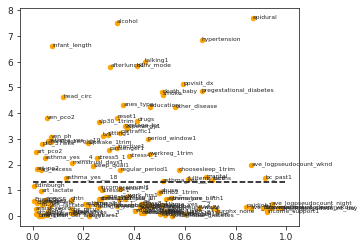

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for k in moi.keys():
    ax.scatter(moi[k][1], moi[k][0], color='orange', s=20)
    ax.text(moi[k][1], moi[k][0], k, size=6)
ax.plot([0, 1], [-np.log10(0.05), -np.log10(0.05)], 'k--')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_errgroupdiffVpredictability_knn.pdf'), bbox_inches='tight')

In [45]:
# metrics of interest
metric = ['mape', 'rho']
moi = {m: [] for m in metric}
for k in resknn.keys():
    if any([True if 'mape' in i else False for i in resknn[k]['predictability'][0].keys()]):
        for m in metric:
            moi[m].append(resknn[k]['predictability'][0][m])
moi

{'mape': [0.16504557589491395,
  0.23159834016714284,
  0.20343106588345855,
  0.07971367636583693,
  0.26209505127524996,
  0.22749038376932276,
  0.20838659595589962,
  0.17502102833729752,
  0.4772650105170178,
  inf,
  0.3505415256408879,
  0.006756054142857217,
  0.12330878358540247,
  0.31951040547877807,
  0.3601114383248298,
  0.23711211268380394,
  0.06782256094704009,
  0.054200020771585505,
  inf,
  0.301160748161633,
  0.3382696004515726,
  0.19044156483302918,
  0.24054732439318957,
  0.48005720809468627,
  0.06229844945452591,
  0.03791086446329722,
  0.36043815732483586,
  nan,
  inf,
  inf,
  inf,
  0.4405963231918762,
  0.287277783185901,
  nan,
  inf],
 'rho': [0.2910853126379809,
  0.02331361774728574,
  0.036055397442785575,
  0.01643522318422764,
  -0.06926076007223733,
  0.044358841478098585,
  0.15125785524866808,
  0.014914385021173742,
  0.017047622970840292,
  0.03222728568863949,
  0.034591656686494276,
  0.07287606567846373,
  0.0557159633070698,
  0.0343638

In [ ]:
# metrics of interest
metric = ['auprc_adj', 'balanced_acc_adj']
moi = {m: [] for m in metric}
for k in resknn.keys():
    if any([True if 'balanced' in i else False for i in resknn[k]['predictability'][0].keys()]):
        for m in metric:
            moi[m].append(resknn[k]['predictability'][0][m])
moi

In [25]:
moi

{'auprc_adj': [(0.6854399464703915, 0.41948763931807764),
  (0.3623036152140992, 0.20818686794585575),
  (0.45881405357722477, 0.17044975618991298),
  (0.013972055888223553, 0.03250914566217097),
  (0.7077760112529283, 0.5223679350196802),
  (0.3400809716599191, 0.15731000641376053),
  (0.6138494116506333, 0.44200414745003547),
  (0.7270176806031794, 0.5949946906511779),
  (0.33291344691135183, 0.33749041671426727),
  (0.5134350827528963, 0.33340762241375815),
  (0.4123732009085148, 0.33288458792726205),
  (0.6669341894317155, 0.34139112743127387),
  (0.6666666666666666, 0.3391402127503552),
  (0.2077266168175259, 0.1758621488365949),
  (0.5109126984126984, 0.026219911119732743),
  (0.1528699861687413, 0.12513693864463407),
  (0.04791666666666667, 0.1025437981513948),
  (0.514344262295082, 0.03141848767396786),
  (0.5277207392197125, 0.060286774416940726),
  (0.5120967741935484, 0.030680435290275754),
  (0.501996007984032, 0.014724314830089003),
  (0.5263671875, 0.0666109508773822),
  

In [73]:
resknn['ptb_37wks']

{'p': 0.0015232546897057332,
 'X': [array([0., 0., 0., ..., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
  